# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измерить *AUC-ROC*, сравнивнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных
**Признаки:**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  

**Целевой признак:**  
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook

#предобработка
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

#модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#метрики
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df_raw = pd.read_csv(r"Churn.csv")
except:
    df_raw = pd.read_csv(r"/datasets/Churn.csv")
    
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# БЛОК МОИХ ФУНКЦИЙ
#====================================================================
def get_corr_table(data_f, title=None, size=(12, 10)):
    """ Строит цветастую таблицу корреляции всего датафрейма """
    pirson = data_f.corr().round(2)

    # Plot
    plt.figure(figsize=size)
    sns.heatmap(
        pirson,
        yticklabels=pirson.index,
        cmap='RdYlGn', center=0,
        annot=True)

    # Decorations
    plt.title(title, fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
#====================================================================
def get_isna(data_f: pd.DataFrame):
    """выводит таблицу пропусков"""
    some_df = pd.concat(
        [data_f.isna().sum().sort_values(),
         (data_f.isna().sum().sort_values() / len(data_f) * 100).round(2)], axis=1)

    some_df.columns = ['абсолют', '%']
    return some_df
#====================================================================
def upsample(features, target, repeat, max_class=0, r_state=2022):
    """увеличивает выборку"""
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]
    
    if max_class == 0:
        features_upsampled = pd.concat(
            [features_0] + [features_1]*repeat
        )

        target_upsampled = pd.concat(
            [target_0] + [target_1]*repeat
        )
    else:
        features_upsampled = pd.concat(
            [features_1] + [features_0]*repeat
        )

        target_upsampled = pd.concat(
            [target_1] + [target_0]*repeat
        )
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=r_state
    )
    return features_upsampled, target_upsampled
#====================================================================
def downsample(features, target, fraction, max_class=0, r_state=2022):
    """уменьшает выборку"""
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]
    
    if max_class == 0:
        features_downsampled = pd.concat(
            [features_0.sample(frac=fraction, random_state=r_state)] + [features_1]
        )
        target_downsampled = pd.concat(
            [target_0.sample(frac=fraction, random_state=r_state)] + [target_1]
        )
    else:
        features_downsampled = pd.concat(
            [features_1.sample(frac=fraction, random_state=r_state)] + [features_0]
        )
        target_downsampled = pd.concat(
            [target_1.sample(frac=fraction, random_state=r_state)] + [target_0]
        )
        
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=r_state
    )
    
    return features_downsampled, target_downsampled

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце tenure пропуски заменим на 0, т.к. врядли сотрудники/система банка проигнорируют  **постоянного** клиента.

In [5]:
df_raw = df_raw.fillna(0)
get_isna(df_raw)

,абсолют,%
RowNumber,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


Приведем названия столбцов к нижнему регистру

In [6]:
df_raw.columns = df_raw.columns.str.lower()
df_raw.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [7]:
df_raw.describe().round()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,5000.0,15690941.0,651.0,39.0,5.0,76486.0,2.0,1.0,1.0,100090.0,0.0
std,2887.0,71936.0,97.0,10.0,3.0,62397.0,1.0,0.0,0.0,57510.0,0.0
min,1.0,15565701.0,350.0,18.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0
25%,2501.0,15628528.0,584.0,32.0,2.0,0.0,1.0,0.0,0.0,51002.0,0.0
50%,5000.0,15690738.0,652.0,37.0,4.0,97199.0,1.0,1.0,1.0,100194.0,0.0
75%,7500.0,15753234.0,718.0,44.0,7.0,127644.0,2.0,1.0,1.0,149388.0,0.0
max,10000.0,15815690.0,850.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0


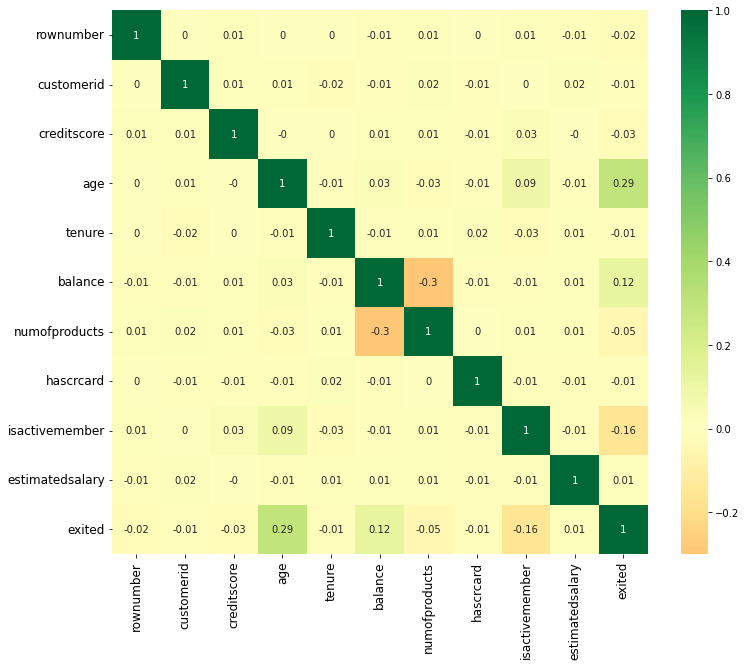

In [8]:
get_corr_table(df_raw)

В данных присутсвует слабая линейная корреляция

Очевидно, что столбцы 'rownumber', 'customerid', 'surname' для обучения модели не важны. Удалим их.

In [9]:
# Обернем в try-except, т.к. в процессе отладки возникающие ошибки могут мешать
try:
    df_raw = df_raw.drop(columns=['rownumber', 'customerid', 'surname'], axis=1)
except:
    pass

Рассмотрим столбец 'geography'. Определим, является ли географическое положение признаком необходимым для обучения модели.

In [10]:
df_raw.groupby('geography').agg({
    'balance':'median',# медианный баланс
    'estimatedsalary':'median',# медианная зарплата
    'age':'count',# сколько клиентов в стране
    'exited':'sum'# сколько клиентов ушло
}).round()

,balance,estimatedsalary,age,exited
geography,,,,
France,62154.0,99132.0,5014,810
Germany,119703.0,102397.0,2509,814
Spain,61710.0,99985.0,2477,413


Как мы видим, граждане разных стран обладают разным финансовым состоянием внутри банковской системы. Оставим этот признак.  
Рассмотрим, так же финансовое состояние в зависимости от пола клиента.

In [11]:
df_raw.groupby('gender').agg({
    'balance':'median',# медианный баланс
    'estimatedsalary':'median',# медианная зарплата
    'age':'count',# сколько клиентов в стране
    'exited':'sum'# сколько клиентов ушло
}).round()

,balance,estimatedsalary,age,exited
gender,,,,
Female,96148.0,101905.0,4543,1139
Male,98065.0,98061.0,5457,898


Женщины больше зарабатывают и чаще уходят. Оставим этот признак

In [12]:
df_raw.groupby('age').agg({
    'balance':'median',# медианный баланс
    'estimatedsalary':'median',# медианная зарплата
    'age':'count',# сколько клиентов в стране
    'exited':'sum'# сколько клиентов ушло
}).sort_values(by='exited', ascending=False).head(15)

,balance,estimatedsalary,age,exited
age,,,,
46,90593.400,95714.150,226,91
40,97552.200,113413.290,432,89
43,102338.190,98586.140,297,88
45,102703.620,115719.080,229,87
48,106822.085,103712.990,168,80
42,95386.820,91429.740,321,77
47,103894.380,107625.460,175,77
49,106160.370,116249.720,147,75
44,98862.540,94862.930,257,73


Люди среднего возраста тоже сколонны уходить

### Подготовка выборок
Разобьем датасет на признаки и целевой признак.

In [13]:
target = df_raw['exited']
features = df_raw.drop(columns='exited', axis=1)

#### Прямое кодирование OHE

In [14]:
# прямое кодирование OHE
features = pd.get_dummies(
    features,
    drop_first=True # избегаем dummy-ловушки
)

# приводим к нижнему регистру
features.columns = features.columns.str.lower()

features.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


#### Разбивка выборок

In [15]:
train_features, valid_features, train_target, valid_target = train_test_split(
    features,
    target,
    train_size=0.6,
    test_size=0.4,
    random_state=2022
)
print(train_features.shape)
print(train_target.shape)

(6000, 11)
(6000,)


Создадим тестовую выборку

In [16]:
valid_features, test_features, valid_target, test_target = train_test_split(
    valid_features, valid_target, test_size=0.5, random_state=2022)

print(valid_features.shape)
print(valid_target.shape)
print(test_features.shape)
print(test_target.shape)

(2000, 11)
(2000,)
(2000, 11)
(2000,)


#### Масштабирование признаков

In [17]:
numeric = ['creditscore', 'age', 'tenure',
           'balance', 'numofproducts', 'hascrcard', 'isactivemember','estimatedsalary']

# масштабирование признаков обучающей выборки
scaler = StandardScaler()

# обучаем стандартизатор на обучающей выборке
scaler.fit(train_features[numeric])
#=======================================================
# применяем пправила к выборке
train_features[numeric] = scaler.transform(train_features[numeric])

# масштабирование признаков валидационной выборки
valid_features[numeric] = scaler.transform(valid_features[numeric])

# масштабирование признаков тестовой выборки
test_features[numeric] = scaler.transform(test_features[numeric])

In [18]:
train_features.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
5678,-0.224339,-0.554332,1.408816,-1.222968,0.822903,0.638584,-1.042572,-0.615261,0,0,1
1617,-0.982105,0.115806,-0.183966,-1.222968,0.822903,-1.565964,0.959166,0.092934,0,1,0
1677,1.374238,0.115806,1.090260,-1.222968,0.822903,0.638584,-1.042572,0.153206,0,1,0
7092,1.104348,0.115806,-0.502523,-1.222968,0.822903,-1.565964,-1.042572,-0.069798,0,1,1
7885,1.457281,0.307274,-1.458193,0.361042,0.822903,0.638584,-1.042572,-0.922820,0,0,0


### Вывод
* Данные изучены и подготовлены к работе.
* Созданы выборки необходимые для обучения и проверки модели.
* Признаки закодированы и отмасштабированы.

## Исследование задачи

Обучим наши модели на "сырых данных". Посмотрим на баланс целевых признаков

In [19]:
df = pd.concat(
    [
        df_raw['exited'].value_counts().round(2),
        df_raw['exited'].value_counts(normalize=True).round(2),
    ], axis=1,
         )
df.columns = ['абсолют','относит']
df

,абсолют,относит
0,7963,0.8
1,2037,0.2


Как видно, наш датасет несбланасирован. Исследуем модели

In [20]:
# датафрейм для хранения лучших результатов обучения
df_train_result = pd.DataFrame(
    columns=['F1_raw', 'AUC_ROC_raw', '|',
             'F1_balanced', 'AUC_ROC_balanced', '|',
             'F1_up', 'AUC_ROC_up', '|',
             'F1_down', 'AUC_ROC_down',
            ],
    
    index=['решающее_дерево',
           'случайный_лес',
           'логистическая_регрессия']
)
df_train_result['|'] =  '|'

### Решающее дерево

  0%|          | 0/25 [00:00<?, ?it/s]

max_depth = 11 
F1_score = 0.5844504021447722 
auc_roc = 0.7859147931181272


<Figure size 432x288 with 0 Axes>

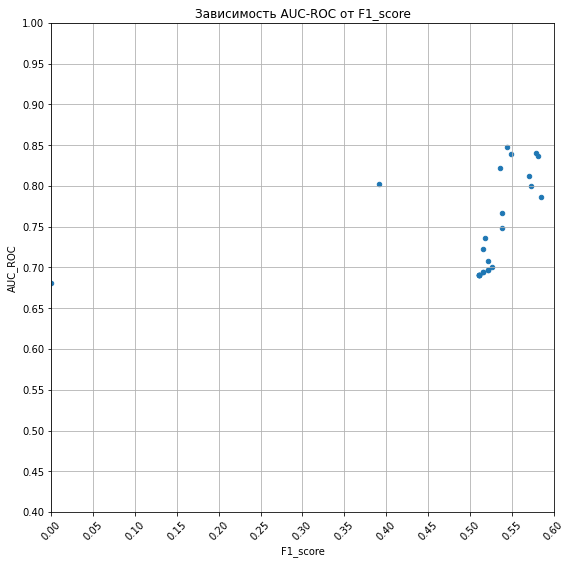

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.0,0.680946
1,2.0,0.538244,0.748
2,3.0,0.390892,0.802473
3,4.0,0.535658,0.822047
4,5.0,0.544872,0.847202
5,6.0,0.549206,0.838979
6,7.0,0.57958,0.840072
7,8.0,0.580838,0.836105
8,9.0,0.570175,0.812403
9,10.0,0.573333,0.800446


In [21]:
# используем датафрейм для неаглядности
df_temp = pd.DataFrame(
    columns=['max_depth', 'F1_score', 'AUC_ROC']
)

best_raw_tree_model = 0
best_tree_depth = 0
best_tree_result = 0
best_tree_aucroc = 0

for depth in tqdm_notebook(range(1, 26, 1)):
    model = DecisionTreeClassifier(
        max_depth=depth,
        random_state=2022)
    
    model.fit(train_features, train_target)
    
    prediction_tree = model.predict(valid_features)
    result = f1_score(valid_target, prediction_tree)
    
    probabilities = model.predict_proba(valid_features)
    probabilities_one = probabilities[:,1]
    auc_roc = roc_auc_score(valid_target, probabilities_one)
    
    df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
        
    if result > best_tree_result:
        best_tree_result = result
        best_tree_depth = depth
        best_raw_tree_model = model
        best_tree_aucroc = auc_roc
        
print(
    "max_depth =", best_tree_depth,
    "\nF1_score =", best_tree_result,
    "\nauc_roc =", best_tree_aucroc
)

df_train_result.loc['решающее_дерево', 'F1_raw'] = best_tree_result
df_train_result.loc['решающее_дерево', 'AUC_ROC_raw'] = best_tree_aucroc

n=0.05
m=0.05
np_xticks = np.arange(0, 1+2*m, n)
np_yticks = np.arange(0, 1+2*m, n)

plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0, 0.6),
        ylim=(0.4, 1),
        grid=True,
        rot=45,
        yticks=np_yticks,
        xticks=np_xticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

### Случайный лес

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 19 
F1 = 0.6153846153846154 
auc_roc = 0.7859147931181272


<Figure size 432x288 with 0 Axes>

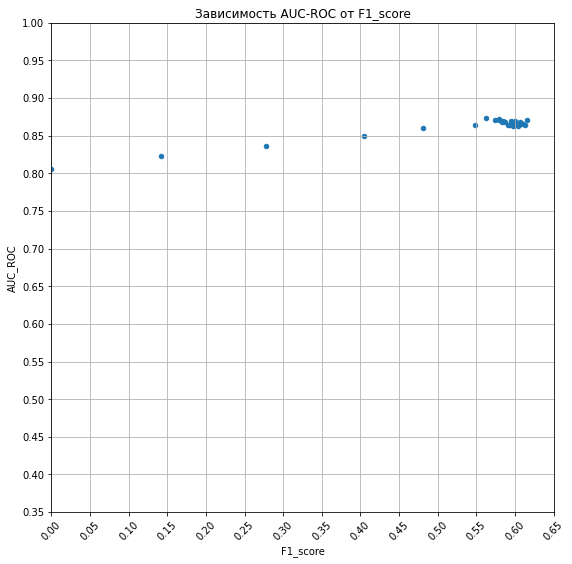

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.0,0.80598
1,2.0,0.142539,0.822979
2,3.0,0.278119,0.836438
3,4.0,0.405253,0.850215
4,5.0,0.481416,0.860393
5,6.0,0.547899,0.864193
6,7.0,0.574675,0.871
7,8.0,0.562197,0.873499
8,9.0,0.580032,0.870329
9,10.0,0.584906,0.870198


In [24]:
df_temp = df_temp.drop(df_temp.index)

best_raw_forest_model = 0
best_forest_depth = 0
# best_forest_estimators = 0
best_forest_result = 0
best_forest_auc_roc = 0

for depth in tqdm_notebook(range(1,31,1)):
#     for estimators in tqdm_notebook(range(115,116,1), leave=False):
        model = RandomForestClassifier(
            random_state=2022,
            max_depth=depth,
            n_estimators = 115,# было найдено до этого
            n_jobs=-1
        )

        model.fit(train_features, train_target)
        prediction = model.predict(valid_features)
        result = f1_score(valid_target, prediction)
        
        probabilities = model.predict_proba(valid_features)
        probabilities_one = probabilities[:,1]
        auc_roc = roc_auc_score(valid_target, probabilities_one)
    
        df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )

        if result > best_forest_result:
            best_forest_result = result
            best_forest_depth = depth
#             best_forest_estimators = estimators
            best_raw_forest_model = model
    
print(
    "max_depth =", best_forest_depth,
#     "\nn_estimators =", best_forest_estimators,
    "\nF1 =", best_forest_result,
    "\nauc_roc =", best_tree_aucroc
)

df_train_result.loc['случайный_лес', 'F1_raw'] = best_forest_result
df_train_result.loc['случайный_лес', 'AUC_ROC_raw'] = best_tree_aucroc


plt.figure()
(
    df_temp
    .round(4)
    .sort_values(by='F1_score')
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0, 0.65),
        ylim=(0.35, 1),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
))
plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

### Логистическая регрессия

In [25]:
model_logistic = LogisticRegression(random_state=2022)
model_logistic.fit(train_features, train_target)
prediction = model_logistic.predict(valid_features)
f1_logistic = f1_score(valid_target, prediction)

probabilities = model_logistic.predict_proba(valid_features)
probabilities_one_logistic = probabilities[:,1]
logistic_auc_roc = roc_auc_score(valid_target, probabilities_one_logistic)
print(
    "F1_score =", f1_logistic,
    "\nAUC_ROC =", logistic_auc_roc
)

df_train_result.loc['логистическая_регрессия', 'F1_raw'] = f1_logistic
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_raw'] = logistic_auc_roc

F1_score = 0.2888086642599278 
AUC_ROC = 0.7797173505667986


### тестирование и ROC-кривая

In [26]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN


Как мы видим модель "случайный лес" - единственная модель, которая преодолела барьер f1_score=0,59

Расммотрим AUC-ROC **всех** моделей на валидационной выборке

In [27]:
prediction_tree_test = best_raw_tree_model.predict(valid_features)
probabilities = best_raw_tree_model.predict_proba(valid_features)
probabilities_one_tree_raw = probabilities[:,1]

# =============================================================================

prediction_forest_test = best_raw_forest_model.predict(valid_features)
probabilities = best_raw_forest_model.predict_proba(valid_features)
probabilities_one_forest_raw = probabilities[:,1]

# =============================================================================
                               
prediction = model_logistic.predict(valid_features)
probabilities = model_logistic.predict_proba(valid_features)
probabilities_one_logistic_raw = probabilities[:,1]

Рассмотрим кривую auc-roc **всех** моделей на валидационной выборке

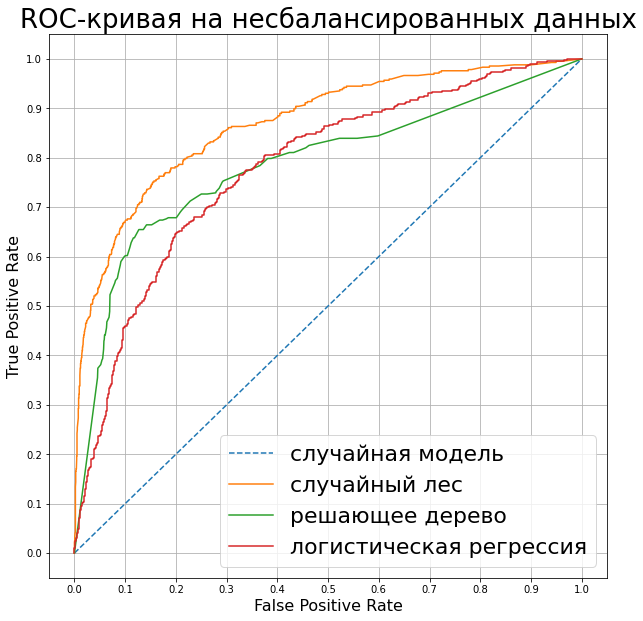

In [28]:
x=np.arange(0, 1.1, 0.1)

fpr_tree_raw, tpr_tree_raw, thresholds = roc_curve(valid_target, probabilities_one_tree_raw)
fpr_forest_raw, tpr_forest_raw, thresholds = roc_curve(valid_target, probabilities_one_forest_raw)
fpr_logistic_raw, tpr_logistic_raw, thresholds = roc_curve(valid_target, probabilities_one_logistic_raw)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

ax.plot([0,1],[0,1], linestyle='--', label='случайная модель')
ax.plot(fpr_forest_raw, tpr_forest_raw, label='случайный лес')
ax.plot(fpr_tree_raw, tpr_tree_raw, label='решающее дерево')
ax.plot(fpr_logistic_raw, tpr_logistic_raw, label='логистическая регрессия')

plt.title('ROC-кривая на несбалансированных данных', fontsize=26)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(x)
plt.yticks(x)
ax.legend(fontsize=22)
ax.grid(True)

plt.show()

### Вывод
В данных сущестует дисбаланс классов в отношении 1:4. Возможно он влияет на качество изучаемых моделей. Обучим модели заново, применяя различные техники устранения дисбаланса

## Борьба с дисбалансом

Для увеличения качества модели при дисбалансе классов существуют техники:
* взвешивание классов,
* upsampling,
* downsampling.

### Взвешивание классов

Для осуществления работы данной техники, необъодимо в качестве параметра модели указать:  

model = LogisticRegression(**class_weight='balanced'**)

#### Логистическая регрессия¶

In [29]:
model_balanced_logistic = LogisticRegression(random_state=2022, class_weight='balanced')
model_balanced_logistic.fit(train_features, train_target)
prediction = model_balanced_logistic.predict(valid_features)
f1_logistic = f1_score(valid_target, prediction)

probabilities = model_balanced_logistic.predict_proba(valid_features)
probabilities_one_logistic = probabilities[:,1]
logistic_auc_roc = roc_auc_score(valid_target, probabilities_one_logistic)
print(
    "F1_score =", f1_logistic,
    "\nAUC_ROC =", logistic_auc_roc
)

df_train_result.loc['логистическая_регрессия', 'F1_balanced'] = f1_logistic
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_balanced'] = logistic_auc_roc

df_train_result

F1_score = 0.5213675213675213 
AUC_ROC = 0.780394509408266


,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,NaN,NaN,|,NaN,NaN


Качество модели значительно выросло. Так же выросла AUC_ROC

#### Решающее дерево

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 8 
f1_score = 0.590513068731849 
f1_score = 0.8257914199278608


<Figure size 432x288 with 0 Axes>

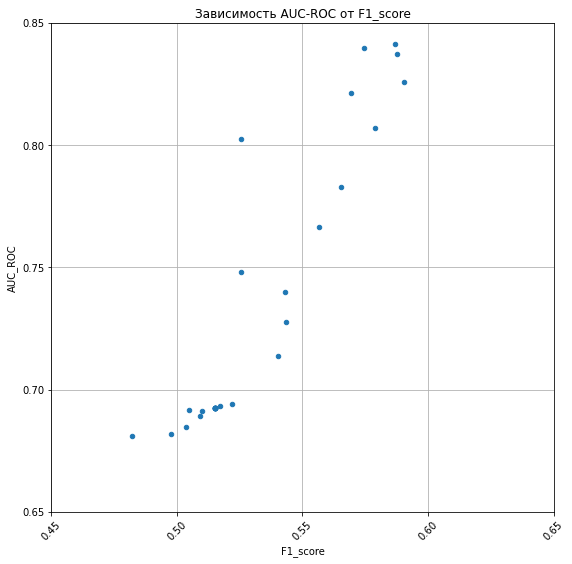

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.482,0.680946
1,2.0,0.525604,0.748
2,3.0,0.525604,0.802473
3,4.0,0.56926,0.821297
4,5.0,0.574526,0.83962
5,6.0,0.586859,0.841375
6,7.0,0.587669,0.837346
7,8.0,0.590513,0.825791
8,9.0,0.578842,0.807114
9,10.0,0.565517,0.783074


In [30]:
df_temp = df_temp.drop(df_temp.index)

best_balanced_tree_model = 0
best_tree_depth = 0
best_tree_result = 0
best_tree_aucroc = 0

for depth in tqdm_notebook(range(1, 31, 1)):
    model = DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=depth,
        random_state=2022)
    
    model.fit(train_features, train_target)
    
    prediction_tree = model.predict(valid_features)
    result = f1_score(valid_target, prediction_tree)
    
    probabilities = model.predict_proba(valid_features)
    probabilities_one = probabilities[:,1]
    auc_roc = roc_auc_score(valid_target, probabilities_one)
    
    df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
    
    if result > best_tree_result:
        best_tree_result = result
        best_tree_depth = depth
        best_balanced_tree_model = model
        best_tree_aucroc = auc_roc
print(
    "max_depth =", best_tree_depth,
    "\nf1_score =", best_tree_result,
    "\nf1_score =", best_tree_aucroc
)


df_train_result.loc['решающее_дерево', 'F1_balanced'] = best_tree_result
df_train_result.loc['решающее_дерево', 'AUC_ROC_balanced'] = best_tree_aucroc


plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),        
        ylim=(0.65, 0.85),
        xlim=(0.45, 0.65),        
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [31]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,NaN,NaN,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,NaN,NaN,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,NaN,NaN,|,NaN,NaN


Качество модели выросло. Увеличилась AUC_ROC.

#### Случайный лес

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 10 
F1_score = 0.6584158415841586 
AUC_ROC = 0.87125801569736


<Figure size 432x288 with 0 Axes>

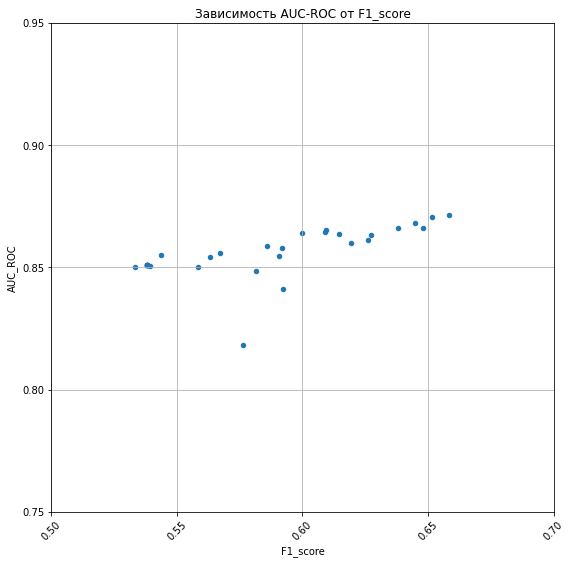

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.576471,0.818287
1,2.0,0.592223,0.841086
2,3.0,0.581506,0.848419
3,4.0,0.626122,0.861432
4,5.0,0.62749,0.863174
5,6.0,0.619433,0.860204
6,7.0,0.647858,0.866038
7,8.0,0.651564,0.870743
8,9.0,0.645012,0.868283
9,10.0,0.658416,0.871258


In [32]:
df_temp = df_temp.drop(df_temp.index)

best_balanced_forest_model = 0
best_forest_depth = 0
# best_forest_estimators = 0
best_forest_result = 0
best_forest_auc_roc = 0

for depth in tqdm_notebook(range(1,31, 1)):
#     for estimators in tqdm_notebook(range(30,34,1), leave=False):
        model = RandomForestClassifier(
            class_weight='balanced',
            random_state=2022,
            max_depth=depth,
            n_estimators = 32,
            n_jobs=-1
        )

        model.fit(train_features, train_target)
        
        prediction = model.predict(valid_features)
        result = f1_score(valid_target, prediction)
        
        probabilities = model.predict_proba(valid_features)
        probabilities_one = probabilities[:,1]
        auc_roc = roc_auc_score(valid_target, probabilities_one)
        
        df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
        
        
        if result > best_forest_result:
            best_forest_result = result
            best_forest_depth = depth
#             best_forest_estimators = estimators
            best_balanced_forest_model = model
            best_forest_auc_roc = auc_roc
    
print(
    "max_depth =", best_forest_depth,
#     "\nn_estimators =", best_forest_estimators,
    "\nF1_score =", best_forest_result,
    "\nAUC_ROC =", best_forest_auc_roc
    
)
df_train_result.loc['случайный_лес', 'F1_balanced'] = best_forest_result
df_train_result.loc['случайный_лес', 'AUC_ROC_balanced'] = best_forest_auc_roc


plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0.5, 0.7),
        ylim=(0.75, 0.95),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [33]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,NaN,NaN,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,NaN,NaN,|,NaN,NaN


Качество модели и AUC_ROC увеличились.

### Увеличение выборки

Для балансировки модели, применяется техника увеличения выборок

In [34]:
df = pd.concat(
    [
        df_raw['exited'].value_counts().round(2),
        df_raw['exited'].value_counts(normalize=True).round(2),
    ], axis=1,
)
df.columns = ['абсолют', 'относит']
df

,абсолют,относит
0,7963,0.8
1,2037,0.2


In [35]:
train_features_up, train_target_up = upsample(train_features, train_target, 4)

# подбираем параметр repeat, проверяя, чтобы соотношение
# классов целевого признака, было близко к соотношению 1:1
print(len(train_features_up[train_target_up == 0]))
print(len(train_features_up[train_target_up == 1]))

print(
    len(train_features_up[train_target_up == 1]) / len(train_features_up[train_target_up == 0])
)

print(
    len(train_features_up[train_target_up == 0]) / len(train_features_up[train_target_up == 1])
)

print(train_features_up.shape)
print(train_target_up.shape)

4796
4816
1.0041701417848208
0.9958471760797342
(9612, 11)
(9612,)


#### Логистическая регрессия¶

In [36]:
model_up_logistic = LogisticRegression(random_state=2022,
#                                        class_weight='balanced'
                                      )

# обучение на увеличенной выборке
model_up_logistic.fit(train_features_up, train_target_up)

# f1 на валидационной выборке
prediction = model_up_logistic.predict(valid_features)
f1_logistic = f1_score(valid_target, prediction)

# auc_roc на валидационной выборке
probabilities = model_balanced_logistic.predict_proba(valid_features)
probabilities_one_logistic = probabilities[:,1]
logistic_auc_roc = roc_auc_score(valid_target, probabilities_one_logistic)
print(
    "F1_score =", f1_logistic,
    "\nAUC_ROC =", logistic_auc_roc
)

df_train_result.loc['логистическая_регрессия', 'F1_up'] = f1_logistic
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_up'] = logistic_auc_roc


df_train_result


F1_score = 0.5209222886421861 
AUC_ROC = 0.780394509408266


,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,NaN,NaN,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,NaN,NaN


Качество модели ухудшилось, AUC_ROC не изменилась в сравнении с предыдущей техникой.

#### Решающее дерево

Переобучим модель с новыми параметрами

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 8 
f1_score = 0.5942173479561316 
f1_score = 0.8218011819224343


<Figure size 432x288 with 0 Axes>

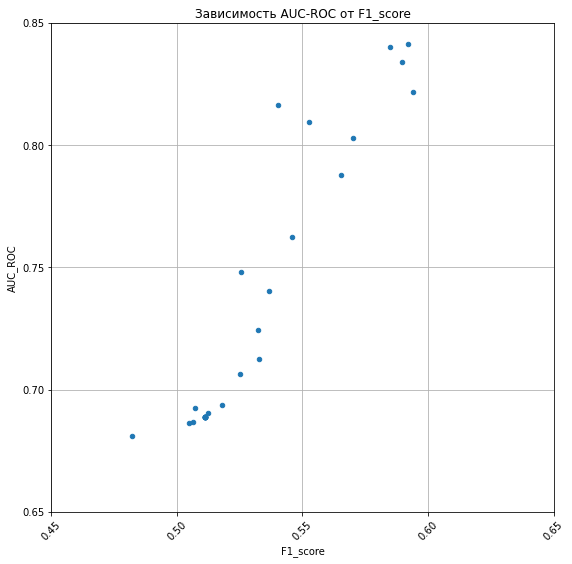

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.482,0.680946
1,2.0,0.525604,0.748
2,3.0,0.552577,0.809409
3,4.0,0.54026,0.816445
4,5.0,0.584995,0.840174
5,6.0,0.592058,0.841512
6,7.0,0.589719,0.83398
7,8.0,0.594217,0.821801
8,9.0,0.570297,0.802929
9,10.0,0.565476,0.787833


In [37]:
df_temp = df_temp.drop(df_temp.index)

best_up_tree_model = 0
best_tree_depth = 0
best_tree_result = 0
best_tree_aucroc = 0

for depth in tqdm_notebook(range(1, 31, 1)):
    model = DecisionTreeClassifier(
#         class_weight='balanced',
        max_depth=depth,
        random_state=2022)
    
    # обучение на увеличенной выборке
    model.fit(train_features_up, train_target_up)
    
    prediction_tree = model.predict(valid_features)
    result = f1_score(valid_target, prediction_tree)
    
    probabilities = model.predict_proba(valid_features)
    probabilities_one = probabilities[:,1]
    auc_roc = roc_auc_score(valid_target, probabilities_one)
    
    df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
    
    if result > best_tree_result:
        best_tree_result = result
        best_tree_depth = depth
        best_up_tree_model = model
        best_tree_aucroc = auc_roc
print(
    "max_depth =", best_tree_depth,
    "\nf1_score =", best_tree_result,
    "\nf1_score =", best_tree_aucroc
)


df_train_result.loc['решающее_дерево', 'F1_up'] = best_tree_result
df_train_result.loc['решающее_дерево', 'AUC_ROC_up'] = best_tree_aucroc

plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0.45, 0.65),
        ylim=(0.65, 0.85),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [38]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,NaN,NaN,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,NaN,NaN


увеличение качества модели, уменьшение AUC_ROC

#### Случайный лес

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 11 
F1_score = 0.6636466591166478 
AUC_ROC = 0.8701718347368852


<Figure size 432x288 with 0 Axes>

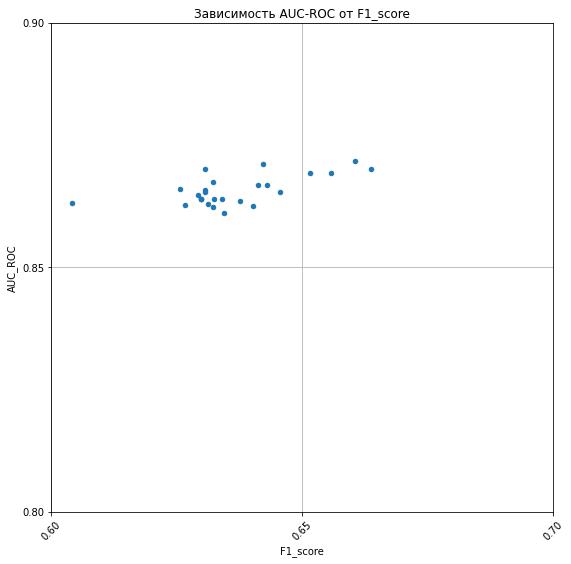

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.514886,0.810617
1,2.0,0.573864,0.83554
2,3.0,0.545136,0.842377
3,4.0,0.587465,0.857172
4,5.0,0.604066,0.863269
5,6.0,0.632207,0.867428
6,7.0,0.630542,0.870179
7,8.0,0.660436,0.871712
8,9.0,0.642105,0.871185
9,10.0,0.655738,0.869208


In [39]:
df_temp = df_temp.drop(df_temp.index)

best_up_forest_model = 0
best_forest_depth = 0
# best_forest_estimators = 0
best_forest_result = 0
best_forest_auc_roc = 0

for depth in tqdm_notebook(range(1,31, 1)):
#     for estimators in tqdm_notebook(range(57,63, 1), leave=False):
        model = RandomForestClassifier(
#             class_weight='balanced',
            random_state=2022,
            max_depth=depth,
            n_estimators = 59,
            n_jobs=-1
        )

        model.fit(train_features_up, train_target_up)
        
        prediction = model.predict(valid_features)
        result = f1_score(valid_target, prediction)
        
        probabilities = model.predict_proba(valid_features)
        probabilities_one = probabilities[:,1]
        auc_roc = roc_auc_score(valid_target, probabilities_one)
        
        df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
        
        
        if result > best_forest_result:
            best_forest_result = result
            best_forest_depth = depth
#             best_forest_estimators = estimators
            best_up_forest_model = model
            best_forest_auc_roc = auc_roc
    
print(
    "max_depth =", best_forest_depth,
#     "\nn_estimators =", best_forest_estimators,
    "\nF1_score =", best_forest_result,
    "\nAUC_ROC =", best_forest_auc_roc
    
)
df_train_result.loc['случайный_лес', 'F1_up'] = best_forest_result
df_train_result.loc['случайный_лес', 'AUC_ROC_up'] = best_forest_auc_roc

plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0.6, 0.7),
        ylim=(0.8, 0.9),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [40]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,NaN,NaN


Уменьшение качества модели, увеличение AUC-ROC

### Уменьшение выборки

Для балансировки модели, применяется техника увеличения выборок

In [41]:
df = pd.concat(
    [
        df_raw['exited'].value_counts().round(2),
        df_raw['exited'].value_counts(normalize=True).round(2),
    ], axis=1,
         )
df.columns = ['абсолют','относит']
df

,абсолют,относит
0,7963,0.8
1,2037,0.2


In [42]:
train_features_down, train_target_down = downsample(train_features, train_target, 0.255)

print(len(train_features_down[train_target_down == 0]))
print(len(train_features_down[train_target_down == 1]))

print(
    len(train_features_down[train_target_down == 1]) / len(train_features_down[train_target_down == 0])
)

print(
    len(train_features_down[train_target_down == 0]) / len(train_features_down[train_target_down == 1])
)

print(train_features_down.shape)
print(train_target_down.shape)

1223
1204
0.9844644317252658
1.01578073089701
(2427, 11)
(2427,)


#### Логистическая регрессия¶

In [43]:
model_down_logistic = LogisticRegression(
    random_state=2022,
#     class_weight='balanced'
)
# обучение уменьшенной выборке
model_down_logistic.fit(train_features_down, train_target_down)

prediction = model_down_logistic.predict(valid_features)
f1_logistic = f1_score(valid_target, prediction)

probabilities = model_balanced_logistic.predict_proba(valid_features)
probabilities_one_logistic = probabilities[:,1]
logistic_auc_roc = roc_auc_score(valid_target, probabilities_one_logistic)
print(
    "F1_score =", f1_logistic,
    "\nAUC_ROC =", logistic_auc_roc
)

df_train_result.loc['логистическая_регрессия', 'F1_down'] = f1_logistic
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_down'] = logistic_auc_roc

df_train_result

F1_score = 0.524505588993981 
AUC_ROC = 0.780394509408266


,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,NaN,NaN
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,0.524506,0.780395


Качество модели увеличилось. AUC_ROC не изменилась.

#### Решающее дерево

  0%|          | 0/25 [00:00<?, ?it/s]

max_depth = 7 
f1_score = 0.5914691943127961 
f1_score = 0.8253058955236316


<Figure size 432x288 with 0 Axes>

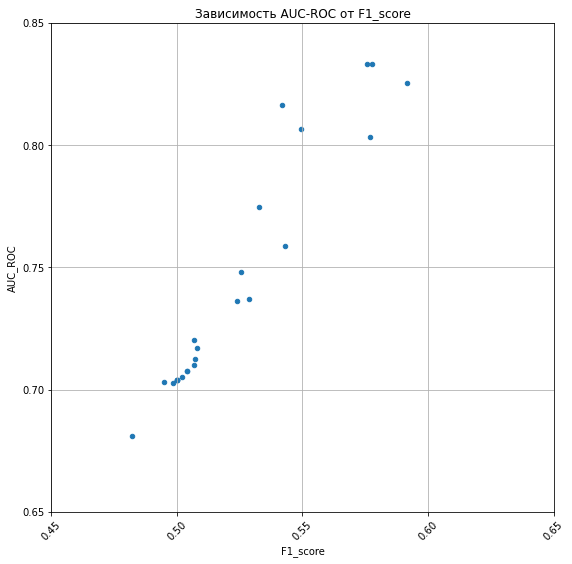

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.482,0.680946
1,2.0,0.525604,0.748
2,3.0,0.549587,0.806436
3,4.0,0.541958,0.816572
4,5.0,0.575673,0.833132
5,6.0,0.577778,0.833305
6,7.0,0.591469,0.825306
7,8.0,0.576846,0.80354
8,9.0,0.532556,0.774605
9,10.0,0.542884,0.758898


In [44]:
df_temp = df_temp.drop(df_temp.index)

best_down_tree_model = 0
best_tree_depth = 0
best_tree_result = 0
best_tree_aucroc = 0

for depth in tqdm_notebook(range(1, 26, 1)):
    model = DecisionTreeClassifier(
#         class_weight='balanced',
        max_depth=depth,
        random_state=2022)
    
    # обучение на уменьшенной выборке
    model.fit(train_features_down, train_target_down)
    
    prediction_tree = model.predict(valid_features)
    result = f1_score(valid_target, prediction_tree)
    
    probabilities = model.predict_proba(valid_features)
    probabilities_one = probabilities[:,1]
    auc_roc = roc_auc_score(valid_target, probabilities_one)
    
    df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
    
    if result > best_tree_result:
        best_tree_result = result
        best_tree_depth = depth
        best_down_tree_model = model
        best_tree_aucroc = auc_roc
print(
    "max_depth =", best_tree_depth,
    "\nf1_score =", best_tree_result,
    "\nf1_score =", best_tree_aucroc
)


df_train_result.loc['решающее_дерево', 'F1_down'] = best_tree_result
df_train_result.loc['решающее_дерево', 'AUC_ROC_down'] = best_tree_aucroc

plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0.45, 0.65),
        ylim=(0.65, 0.85),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [45]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,0.591469,0.825306
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,NaN,NaN
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,0.524506,0.780395


Качество снизилось, AUC_ROC увеличилось

#### Случайный лес

  0%|          | 0/30 [00:00<?, ?it/s]

max_depth = 11 
F1_score = 0.6393762183235868 
AUC_ROC = 0.866284609709579


<Figure size 432x288 with 0 Axes>

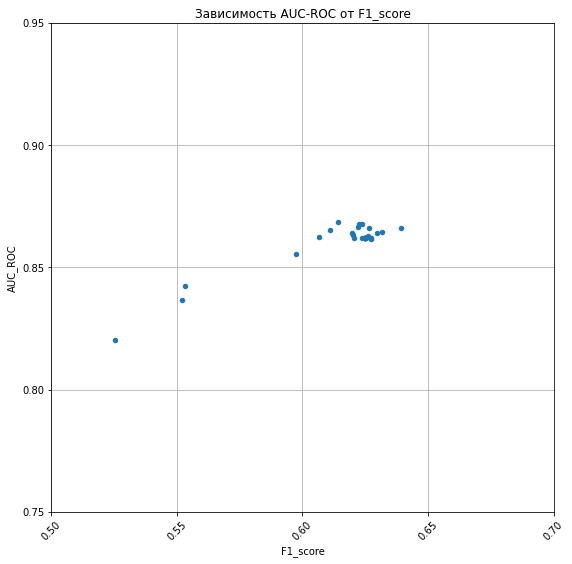

""


,max_depth,F1_score,AUC_ROC
0,1.0,0.52516,0.820386
1,2.0,0.551849,0.836569
2,3.0,0.553191,0.842539
3,4.0,0.597549,0.855655
4,5.0,0.606635,0.862632
5,6.0,0.611006,0.865244
6,7.0,0.614203,0.868683
7,8.0,0.623782,0.867603
8,9.0,0.626341,0.866068
9,10.0,0.622351,0.86778


In [46]:
df_temp = df_temp.drop(df_temp.index)

best_down_forest_model = 0
best_forest_depth = 0
# best_forest_estimators = 0
best_forest_result = 0
best_forest_auc_roc = 0

for depth in tqdm_notebook(range(1,31, 1)):
#     for estimators in tqdm_notebook(range(86,90,1), leave=False):
        model = RandomForestClassifier(
#             class_weight='balanced',
            random_state=2022,
            max_depth=depth,
            n_estimators = 88,
            n_jobs=-1
        )
        # обучение на уменьшенной выборке
        model.fit(train_features_down, train_target_down)
        
        prediction = model.predict(valid_features)
        result = f1_score(valid_target, prediction)
        
        probabilities = model.predict_proba(valid_features)
        probabilities_one = probabilities[:,1]
        auc_roc = roc_auc_score(valid_target, probabilities_one)
        
        df_temp = df_temp.append(
        {'max_depth': depth, 'F1_score':result, 'AUC_ROC':auc_roc}, ignore_index=True
    )
        
        
        if result > best_forest_result:
            best_forest_result = result
            best_forest_depth = depth
#             best_forest_estimators = estimators
            best_down_forest_model = model
            best_forest_auc_roc = auc_roc
    
print(
    "max_depth =", best_forest_depth,
#     "\nn_estimators =", best_forest_estimators,
    "\nF1_score =", best_forest_result,
    "\nAUC_ROC =", best_forest_auc_roc
    
)
df_train_result.loc['случайный_лес', 'F1_down'] = best_forest_result
df_train_result.loc['случайный_лес', 'AUC_ROC_down'] = best_forest_auc_roc

plt.figure()
(
    df_temp
    .round(4) # округляем
    .sort_values(by='F1_score') # сортируем по F1
    .plot(
        kind='scatter',
        x='F1_score',
        y='AUC_ROC',
        figsize=(9,9),
        xlim=(0.5, 0.7),
        ylim=(0.75, 0.95),
        grid=True,
        rot=45,
        xticks=np_xticks,
        yticks=np_yticks
));

plt.title('Зависимость AUC-ROC от F1_score')
plt.show()
display(df_temp.corr().round(2))
display(df_temp)

In [47]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,0.591469,0.825306
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,0.639376,0.866285
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,0.524506,0.780395


Качество значительно испортилось

### Вывод

In [48]:
df_train_result

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,0.591469,0.825306
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,0.639376,0.866285
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,0.524506,0.780395


- Значительный прирост в качестве дают техники взвешивания классов и увеличения выборки.
- Лучшая модель - 'случайный лес'.
- 'Решающее_дерево' прошла порог F1_score = 0,59 с помощью увеличения выборки
- Показана зависимость F1-меры и площади ROC-кривой. Показана корреляция между этими мерами.

## Тестирование модели

In [49]:
df_test_result = pd.DataFrame()

Лучшей моделью, является модель случайного леса, обученной с помощью взвешивания классов.  
Параметры модели:

In [50]:
# параметры модели
best_balanced_forest_model

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=32,
                       n_jobs=-1, random_state=2022)

Проетстируем все модели, обученные с помощью техники взвешивания классов

In [51]:
# тестирование решающего дерева
prediction_tree_test = best_balanced_tree_model.predict(test_features)

f1_tree = f1_score(test_target, prediction_tree_test)

probabilities = best_balanced_tree_model.predict_proba(test_features)

probabilities_one_tree_balance = probabilities[:,1]

tree_auc_roc = roc_auc_score(test_target, probabilities_one_tree_balance)

df_test_result.loc['решающее_дерево', 'F1'] = f1_tree
df_test_result.loc['решающее_дерево', 'AUC_ROC'] = tree_auc_roc
# =============================================================================
# тестирование случайного леса
prediction_forest_test = best_balanced_forest_model.predict(test_features)

f1_forest = f1_score(test_target, prediction_forest_test)

probabilities = best_balanced_forest_model.predict_proba(test_features)

probabilities_one_forest_balance = probabilities[:,1]

forest_auc_roc = roc_auc_score(test_target, probabilities_one_forest_balance)

df_test_result.loc['случайный_лес', 'F1'] = f1_forest
df_test_result.loc['случайный_лес', 'AUC_ROC'] = forest_auc_roc
# =============================================================================
# тестирование логистической ргерессии
prediction = model_balanced_logistic.predict(valid_features)

f1_logistic = f1_score(valid_target, prediction)

probabilities = model_balanced_logistic.predict_proba(test_features)

probabilities_one_logistic_balance = probabilities[:,1]

logistic_auc_roc = roc_auc_score(test_target, probabilities_one_logistic_balance)

df_test_result.loc['логистическая_регрессия', 'F1'] = f1_logistic
df_test_result.loc['логистическая_регрессия', 'AUC_ROC'] = logistic_auc_roc

df_test_result

,F1,AUC_ROC
решающее_дерево,0.541899,0.796326
случайный_лес,0.609412,0.852725
логистическая_регрессия,0.521368,0.766223


Ни одна модель не прошла барьер F1_score=0.59.  
Рассмотрим модели, обченные на увеличенных выборках

In [52]:
# тестирование решающего дерева
prediction_tree_test = best_up_tree_model.predict(test_features)

f1_tree = f1_score(test_target, prediction_tree_test)

probabilities = best_up_tree_model.predict_proba(test_features)

probabilities_one_tree_balance = probabilities[:,1]

tree_auc_roc = roc_auc_score(test_target, probabilities_one_tree_balance)

df_test_result.loc['решающее_дерево', 'F1'] = f1_tree
df_test_result.loc['решающее_дерево', 'AUC_ROC'] = tree_auc_roc
# =============================================================================
# тестирование случайного леса
prediction_forest_test = best_up_forest_model.predict(test_features)

f1_forest = f1_score(test_target, prediction_forest_test)

probabilities = best_up_forest_model.predict_proba(test_features)

probabilities_one_forest_balance = probabilities[:,1]

forest_auc_roc = roc_auc_score(test_target, probabilities_one_forest_balance)

df_test_result.loc['случайный_лес', 'F1'] = f1_forest
df_test_result.loc['случайный_лес', 'AUC_ROC'] = forest_auc_roc
# =============================================================================
# тестирование логистической ргерессии
prediction = model_up_logistic.predict(valid_features)

f1_logistic = f1_score(valid_target, prediction)

probabilities = model_up_logistic.predict_proba(test_features)

probabilities_one_logistic_balance = probabilities[:,1]

logistic_auc_roc = roc_auc_score(test_target, probabilities_one_logistic_balance)

df_test_result.loc['логистическая_регрессия', 'F1'] = f1_logistic
df_test_result.loc['логистическая_регрессия', 'AUC_ROC'] = logistic_auc_roc

df_test_result

,F1,AUC_ROC
решающее_дерево,0.545106,0.793871
случайный_лес,0.601751,0.847638
логистическая_регрессия,0.520922,0.766226


Судя по выводам на тестовой выборке, при относительном равенстве двух F1, метрика AUC_ROC является предпочтительнее при выборе лучшей модели.  
Возможно, эта гипотеза верна при относительном равенстве AUC_ROC  и различии F1_score.  
Вывод в п.3 ошибочен.


Построим ROC-кривую моделей

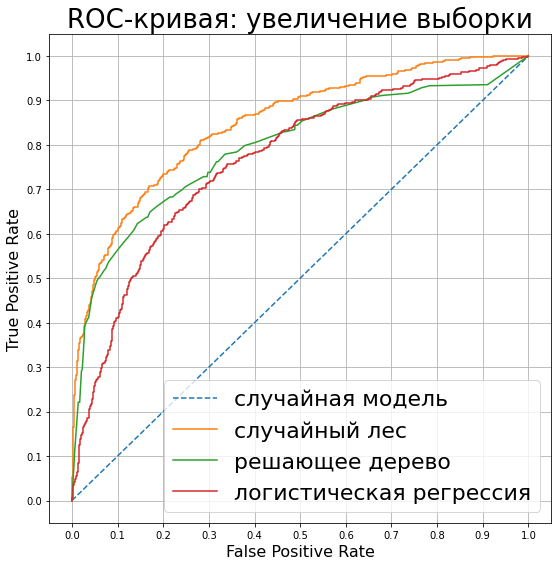

In [53]:
fpr_tree_balance, tpr_tree_balance, thresholds = roc_curve(test_target, probabilities_one_tree_balance)
fpr_forest_balance, tpr_forest_balance, thresholds = roc_curve(test_target, probabilities_one_forest_balance)
fpr_logistic_balance, tpr_logistic_balance, thresholds = roc_curve(test_target, probabilities_one_logistic_balance)

fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)

ax.plot([0,1],[0,1], linestyle='--', label='случайная модель')
ax.plot(fpr_forest_balance,tpr_forest_balance, label='случайный лес')
ax.plot(fpr_tree_balance, tpr_tree_balance, label='решающее дерево')
ax.plot(fpr_logistic_balance, tpr_logistic_balance, label='логистическая регрессия')

plt.title('ROC-кривая: увеличение выборки', fontsize=26)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(x)
plt.yticks(x)
ax.legend(fontsize=22)
ax.grid(True)

plt.show()

## ВЫВОД

In [54]:
print('Метрики моделей на валидационных выборках')
display(df_train_result)
print('Метрики моделей обученных с помощью увеличения выборок на тестовых выборках')
display(df_test_result)

Метрики моделей на валидационных выборках


,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|,F1_down,AUC_ROC_down
решающее_дерево,0.58445,0.785915,|,0.590513,0.825791,|,0.594217,0.821801,|,0.591469,0.825306
случайный_лес,0.615385,0.785915,|,0.658416,0.871258,|,0.663647,0.870172,|,0.639376,0.866285
логистическая_регрессия,0.288809,0.779717,|,0.521368,0.780395,|,0.520922,0.780395,|,0.524506,0.780395


Метрики моделей обученных с помощью увеличения выборок на тестовых выборках


,F1,AUC_ROC
решающее_дерево,0.545106,0.793871
случайный_лес,0.601751,0.847638
логистическая_регрессия,0.520922,0.766226


- Была проанализирована работа различных алгоритмов обучения с различными параметрами.
- Показана зависимость метрик F1 и AUC_ROC.
- Лучшей моделью является модель случайного леса.
- Лучшая техника борьбы с дисбалансом - увеличение выборки:
    - при выборе лучшей техники необходимо обращать внимание на различные метрики, а не заострять внимание на одной
- Проанализирован график ROC-кривой. Чем лучше модель, тем линия графика стремится прижаться к краям осей графика. Напротив, чем хуже, тем линия стремится прижаться к графику случайной модели.